In [7]:
from __future__ import print_function, division
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

plt.ion() 

PyTorch Version:  1.0.1.post2
Torchvision Version:  0.2.2


In [8]:
data_dir = "Retinal"

model_name = "squeezenet"

num_classes = 2
batch_size = 8
num_epochs = 15
feature_extract = True

In [9]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    val_acc_history = []    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [10]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [11]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes,
                                        feature_extract, use_pretrained=True)
print(model_ft)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /home/nebex/.torch/models/squeezenet1_0-a815701f.pth
5017600it [00:12, 402811.92it/s]


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 32, kerne

In [12]:
# Data augmentation 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val']}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x],
                                                   batch_size=batch_size,
                                                   shuffle=True, num_workers=4)
                    for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [13]:
# Send the model to GPU
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [14]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict,
                             criterion, optimizer_ft, num_epochs=num_epochs,
                             is_inception=(model_name=="inception"))

Epoch 0/14
----------
train Loss: 0.6688 Acc: 0.6500
val Loss: 0.6231 Acc: 0.7313

Epoch 1/14
----------
train Loss: 0.6074 Acc: 0.6813
val Loss: 0.6558 Acc: 0.5375

Epoch 2/14
----------
train Loss: 0.5663 Acc: 0.7188
val Loss: 0.5626 Acc: 0.7563

Epoch 3/14
----------
train Loss: 0.4924 Acc: 0.7875
val Loss: 0.4701 Acc: 0.7812

Epoch 4/14
----------
train Loss: 0.4940 Acc: 0.7625
val Loss: 0.4717 Acc: 0.8000

Epoch 5/14
----------
train Loss: 0.4471 Acc: 0.7625
val Loss: 0.4280 Acc: 0.8063

Epoch 6/14
----------
train Loss: 0.4087 Acc: 0.8063
val Loss: 0.4194 Acc: 0.8500

Epoch 7/14
----------
train Loss: 0.4179 Acc: 0.8188
val Loss: 0.3819 Acc: 0.8313

Epoch 8/14
----------
train Loss: 0.3896 Acc: 0.8313
val Loss: 0.3921 Acc: 0.8438

Epoch 9/14
----------
train Loss: 0.3902 Acc: 0.8063
val Loss: 0.3692 Acc: 0.8438

Epoch 10/14
----------
train Loss: 0.4019 Acc: 0.8250
val Loss: 0.3512 Acc: 0.8500

Epoch 11/14
----------
train Loss: 0.3472 Acc: 0.8375
val Loss: 0.3403 Acc: 0.8375

Ep

In [18]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name,
                                   num_classes, feature_extract=False,
                                   use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict,
                             scratch_criterion, scratch_optimizer, num_epochs=num_epochs, 
                             is_inception=(model_name=="inception"))

Epoch 0/14
----------
train Loss: 0.6863 Acc: 0.6250
val Loss: 0.6667 Acc: 0.6250

Epoch 1/14
----------
train Loss: 0.6648 Acc: 0.6250
val Loss: 0.6566 Acc: 0.6250

Epoch 2/14
----------
train Loss: 0.6557 Acc: 0.6250
val Loss: 0.6698 Acc: 0.6250

Epoch 3/14
----------
train Loss: 0.6734 Acc: 0.6250
val Loss: 0.6556 Acc: 0.6250

Epoch 4/14
----------
train Loss: 0.6592 Acc: 0.6250
val Loss: 0.6509 Acc: 0.6250

Epoch 5/14
----------
train Loss: 0.6497 Acc: 0.6250
val Loss: 0.6453 Acc: 0.6250

Epoch 6/14
----------
train Loss: 0.6529 Acc: 0.6250
val Loss: 0.6464 Acc: 0.6250

Epoch 7/14
----------
train Loss: 0.6469 Acc: 0.6250
val Loss: 0.6389 Acc: 0.6250

Epoch 8/14
----------
train Loss: 0.6485 Acc: 0.6250
val Loss: 0.6446 Acc: 0.6250

Epoch 9/14
----------
train Loss: 0.6327 Acc: 0.6250
val Loss: 0.6614 Acc: 0.6250

Epoch 10/14
----------
train Loss: 0.6617 Acc: 0.6250
val Loss: 0.6339 Acc: 0.6250

Epoch 11/14
----------
train Loss: 0.6680 Acc: 0.6250
val Loss: 0.6410 Acc: 0.6250

Ep

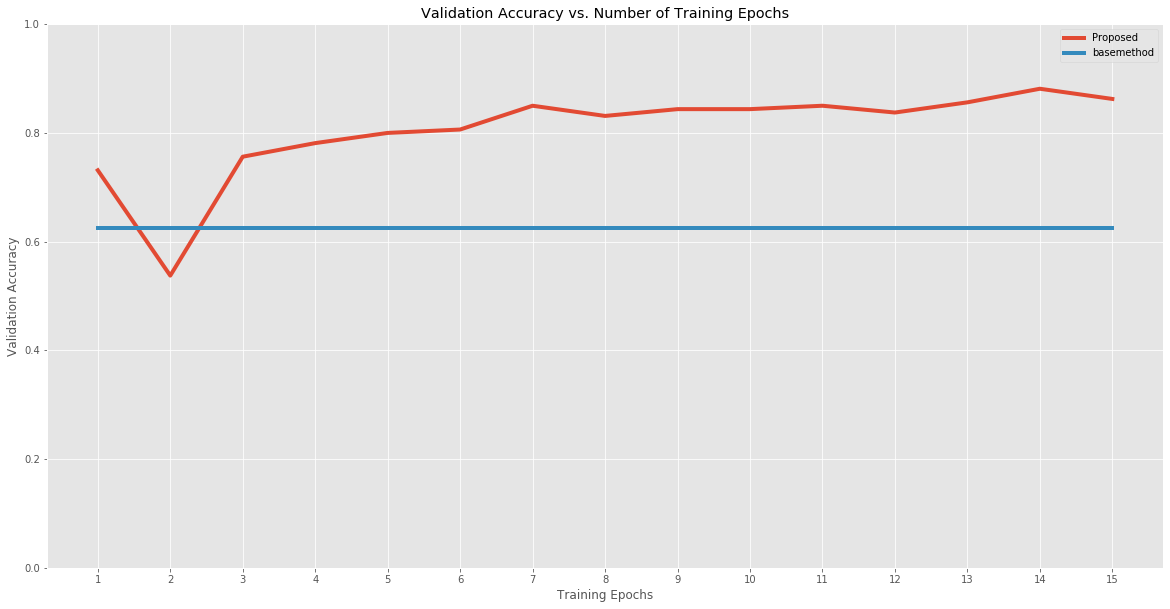

In [24]:
plt.style.use('ggplot')
ohist = []
shist = []
ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]
plt.figure(figsize=(20,10))
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist, linewidth=4,label="Proposed")
plt.plot(range(1,num_epochs+1),shist, linewidth=4,label="basemethod")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()